In [1]:
import torch
from torch import nn
import numpy as np
import sys
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import importlib

sys.path.append("..")
from model import ParticleEventTransformer
from data import get_database_path, get_h5_files, read_h5_file, select_events
from utils import load_toml_config

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"
random_seed = 114514
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [2]:
EMD_config = load_toml_config("EMD")
particle_type_scale = EMD_config['particle_type_scale']

model_hyper_parameters = load_toml_config("Transformer")
output_dim = model_hyper_parameters["output_dim"]

# Load embedding points

In [3]:
import h5py
embedding_points = h5py.File("../embedding_points.h5", "r")

In [4]:
from analysis import Normalizer
normalizer = Normalizer(*[value for value in embedding_points.values()])

In [5]:
print(normalizer.max)
print(normalizer.min)

[369.1842041  370.31808472 327.48770142 326.72790527]
[-377.18408203 -356.34307861 -320.93734741 -340.06167603]


# Split embed points

In [6]:
tpr_dict = {}
fpr_dict = {}
auc_dict = {}

In [7]:
from analysis import create_exp_bkg_events, train_test_split, get_dataloaders

In [15]:
test_ratio=0.2
val_ratio = 0.2
sig_lambda = 0.5
n = 200000

# test_signal = "neutral_boson"
# test_signal = "leptoquark"
test_signal = "neutral_Higgs"
# test_signal = "charged_Higgs"

exp_events, bkg_events = create_exp_bkg_events(np.array(embedding_points['SM']), np.array(embedding_points[test_signal]), sig_lambda, n)
X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
n1 = len(W1)
m1 = len(X1)
pi = n1 / (n1 + m1)
n2 = len(W2)
m2 = len(X2)
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer)

# Classify Model

In [16]:
from model import MLP
hidden_dim = [8, 16, 16, 16, 8]
naive_model = MLP(output_dim, hidden_sizes=hidden_dim)

# Train

In [17]:
from metrics import BinaryACCUpdater

In [18]:
naive_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

In [19]:
from classify import train_model

In [20]:
# opt_train_model  = torch.compile(train_model)

In [21]:
train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50
    )


================================================================================2024-06-22 23:14:26
Epoch 1 / 50

100%|██████████| 250/250 [00:00<00:00, 506.25it/s, val_Accuracy=0.586, val_loss=0.661]
<<<<<< reach best val_Accuracy : 0.5856406688690186 >>>>>>

================================================================================2024-06-22 23:14:36
Epoch 2 / 50

100%|██████████| 250/250 [00:00<00:00, 673.50it/s, val_Accuracy=0.586, val_loss=0.661]
<<<<<< reach best val_Accuracy : 0.5856562852859497 >>>>>>

================================================================================2024-06-22 23:14:45
Epoch 3 / 50

100%|██████████| 250/250 [00:00<00:00, 650.41it/s, val_Accuracy=0.587, val_loss=0.659]
<<<<<< reach best val_Accuracy : 0.5866406559944153 >>>>>>

================================================================================2024-06-22 23:14:55
Epoch 4 / 50

100%|██████████| 250/250 [00:00<00:00, 469.22it/s, val_Accuracy=0.59, val_loss=0.657] 
<<<<<< reach be

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,0.664074,0.583398,0.661478,0.585641,1
1,0.661882,0.584731,0.660515,0.585656,2
2,0.660566,0.584785,0.658687,0.586641,3
3,0.659322,0.586035,0.656818,0.590094,4
4,0.658428,0.589227,0.656477,0.590156,5
5,0.657833,0.589953,0.656409,0.589516,6
6,0.657348,0.590867,0.656149,0.593734,7
7,0.656705,0.592809,0.656588,0.590563,8
8,0.656564,0.593441,0.656473,0.594016,9
9,0.656360,0.594980,0.654749,0.599313,10


# ROC

In [22]:
from analysis import predict

In [97]:
targets, predictions = predict(naive_model, val_dataloader)

100%|██████████| 250/250 [00:00<00:00, 1050.75it/s]


0.6389491435546875


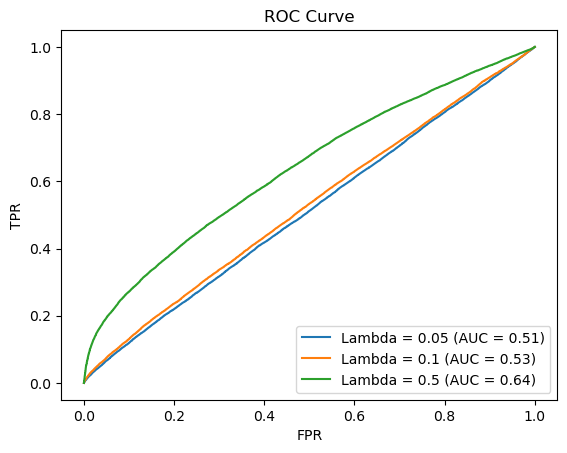

In [98]:
from analysis import calculate_auc
from visualize import plot_roc_curve
fpr, tpr, auc_roc = calculate_auc(targets, predictions)
print(auc_roc)
fpr_dict[str(sig_lambda)] = fpr
tpr_dict[str(sig_lambda)] = tpr
auc_dict[str(sig_lambda)] = auc_roc
plot_roc_curve(fpr_dict, tpr_dict, auc_dict, "ROC Curve")

# Bootstrapped Uncertainty Intervals for λ

## Bootstrap

In [20]:
lambda_mean_dict = {}
lambda_std_dict = {}

lrt_p_permutation_dict = {}
lrt_p_bootstrap_dict = {}
auc_p_permutation_dict = {}
auc_p_bootstrap_dict = {}
mce_p_permutation_dict = {}
mce_p_bootstrap_dict = {}

lrt_p_dict = {}
auc_p_dict = {}
mce_p_dict = {}

In [21]:
import importlib
import classify
import analysis
importlib.reload(classify)
importlib.reload(analysis)
from classify import train_model
from analysis import Bootstrap_Permutation
opt_train_model  = torch.compile(train_model)
from analysis import LambdaEstimator

In [22]:
threshold_dict = load_toml_config("threshold")
print(threshold_dict)

{'lrt': 0.034097843445638314, 'mce': 0.49787375, 'auc': 0.5044355698749999}


In [23]:
n_bootstrap = 10


test_ratio=0.2
val_ratio = 0.2
n = 200000
n_null = 1000

test_signal = "neutral_boson"
# test_signal = "leptoquark"
# test_signal = "neutral_Higgs"
# test_signal = "charged_Higgs"
significance = 0.05


test_lambdas = [0.01, 0.02, 0.05, 0.1]

for i in tqdm(range(len(test_lambdas)), position=0, leave=True):
    sig_lambda = test_lambdas[i]

    estimated_lambdas = np.zeros(n_bootstrap)

    lrt_permutation_power = 0
    lrt_bootstrap_power = 0
    auc_permutation_power = 0
    auc_bootstrap_power = 0
    mce_permutation_power = 0
    mce_bootstrap_power = 0

    lrt_power =0 
    auc_power = 0
    mce_power = 0
    for j in tqdm(range(n_bootstrap), position=1, leave=False):
        exp_events, bkg_events = create_exp_bkg_events(embedding_points['SM'], embedding_points[test_signal], sig_lambda, n)
        X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
        n1 = len(W1)
        m1 = len(X1)
        n2 = len(W2)
        m2 = len(X2)
        train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer)

        hidden_dim = [8, 16, 16, 16, 8]
        naive_model = MLP(output_dim, hidden_sizes=hidden_dim)
        naive_model.to(device)
        optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
        loss_fn = nn.BCELoss()
        acc_metric = BinaryACCUpdater()
        metric_dict = {"Accuracy": acc_metric}

        train_model(
            naive_model, optimizer,
            loss_fn, metrics_dict=metric_dict,
            train_dataloader=train_dataloader, val_dataloader=val_dataloader,
            monitor="val_Accuracy", mode="max",
            epochs=50,
            verbose=False
            )
        
        bootstrap_permutation = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)
        _, _, _ = bootstrap_permutation.bootstrap(n_null, verbose=False)
        _, _, _ = bootstrap_permutation.permutation(n_null, verbose=False)
        if bootstrap_permutation.lrt_p_permutation < significance:
            lrt_permutation_power += 1
        if bootstrap_permutation.lrt_p_bootstrap < significance:
            lrt_bootstrap_power += 1
        if bootstrap_permutation.auc_p_permutation < significance:
            auc_permutation_power += 1
        if bootstrap_permutation.auc_p_bootstrap < significance:
            auc_bootstrap_power += 1
        if bootstrap_permutation.mce_p_permutation < significance:
            mce_permutation_power += 1
        if bootstrap_permutation.mce_p_bootstrap < significance:
            mce_bootstrap_power += 1

        if bootstrap_permutation.lrt_exp > threshold_dict["lrt"]:
            lrt_power += 1

        if bootstrap_permutation.mce_exp < threshold_dict["mce"]:
            mce_power += 1

        if bootstrap_permutation.auc_exp > threshold_dict["auc"]:
            auc_power += 1

        lambda_estimator = LambdaEstimator(X2, W2, naive_model, T=0.5, n_bins=20, normalizer=normalizer)
        estimated_lambdas[j] = lambda_estimator.estimated_lambda
    print("sig_lambda:", sig_lambda, "estimated lambda mean:", estimated_lambdas.mean(), "estimated lambda std:", estimated_lambdas.std())
    lambda_mean_dict[str(sig_lambda)] = estimated_lambdas.mean()
    lambda_std_dict[str(sig_lambda)] = estimated_lambdas.std(ddof = 1)

    lrt_p_permutation_dict[str(sig_lambda)] = lrt_permutation_power
    lrt_p_bootstrap_dict[str(sig_lambda)] = lrt_bootstrap_power
    auc_p_permutation_dict[str(sig_lambda)] = auc_permutation_power
    auc_p_bootstrap_dict[str(sig_lambda)] = auc_bootstrap_power
    mce_p_permutation_dict[str(sig_lambda)] = mce_permutation_power
    mce_p_bootstrap_dict[str(sig_lambda)] = mce_bootstrap_power

    lrt_p_dict[str(sig_lambda)] = lrt_power
    auc_p_dict[str(sig_lambda)] = auc_power
    mce_p_dict[str(sig_lambda)] = mce_power


 25%|██▌       | 1/4 [1:08:46<3:26:19, 4126.59s/it]

sig_lambda: 0.01 estimated lambda mean: 0.01797721546570069 estimated lambda std: 0.01934886181059628


 50%|█████     | 2/4 [2:20:05<2:20:32, 4216.22s/it]

sig_lambda: 0.02 estimated lambda mean: 0.024901550980378672 estimated lambda std: 0.014398679047506626


 75%|███████▌  | 3/4 [3:33:25<1:11:39, 4299.97s/it]

sig_lambda: 0.05 estimated lambda mean: 0.06086537102921078 estimated lambda std: 0.013010644069665222


In [1]:
print(estimated_lambdas)
print(lambda_mean_dict)
print(lambda_std_dict)

NameError: name 'estimated_lambdas' is not defined

In [ ]:
import visualize
importlib.reload(visualize)
from visualize import plot_lambda

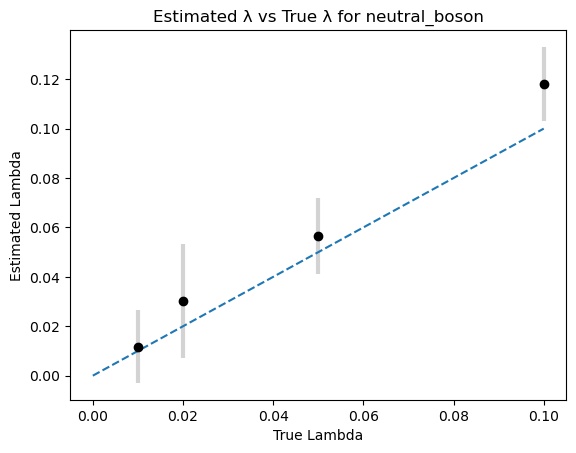

In [ ]:
plot_lambda(lambda_mean_dict, lambda_std_dict, test_signal)

In [ ]:
print(lrt_p_permutation_dict)
print(lrt_p_bootstrap_dict)
print(auc_p_permutation_dict)
print(auc_p_bootstrap_dict)
print(mce_p_permutation_dict)
print(mce_p_bootstrap_dict)

{'0.01': 0, '0.02': 0, '0.05': 0, '0.1': 0}
{'0.01': 0, '0.02': 0, '0.05': 0, '0.1': 0}
{'0.01': 0, '0.02': 0, '0.05': 0, '0.1': 7}
{'0.01': 0, '0.02': 0, '0.05': 0, '0.1': 0}
{'0.01': 0, '0.02': 0, '0.05': 0, '0.1': 10}
{'0.01': 0, '0.02': 0, '0.05': 0, '0.1': 0}


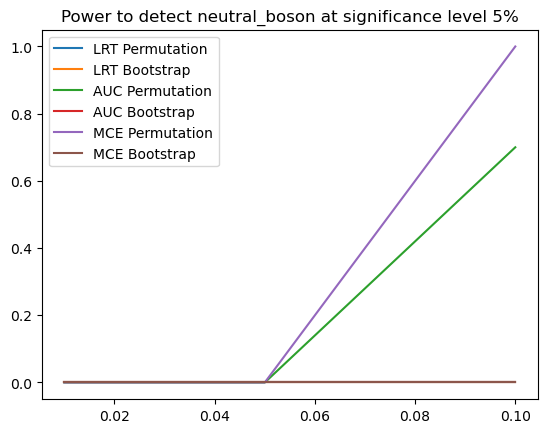

In [ ]:
plt.plot(test_lambdas, np.array([lrt_p_permutation_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="LRT Permutation")
plt.plot(test_lambdas, np.array([lrt_p_bootstrap_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="LRT Bootstrap")
plt.plot(test_lambdas, np.array([auc_p_permutation_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="AUC Permutation")
plt.plot(test_lambdas, np.array([auc_p_bootstrap_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="AUC Bootstrap")
plt.plot(test_lambdas, np.array([mce_p_permutation_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="MCE Permutation")
plt.plot(test_lambdas, np.array([mce_p_bootstrap_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="MCE Bootstrap")
plt.title("Power to detect {} at significance level {:.0%}".format(test_signal, significance))
plt.legend()
plt.show()

In [108]:
import pandas as pd
power_df = pd.DataFrame(columns=test_lambdas)
power_df.loc["LRT Permutation"] = [lrt_p_permutation_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["LRT Bootstrap"] = [lrt_p_bootstrap_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["AUC Permutation"] = [auc_p_permutation_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["AUC Bootstrap"] = [auc_p_bootstrap_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["MCE Permutation"] = [mce_p_permutation_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["MCE Bootstrap"] = [mce_p_bootstrap_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]

power_df.loc["LRT Power"] = [lrt_p_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["AUC Power"] = [auc_p_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["MCE Power"] = [mce_p_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]

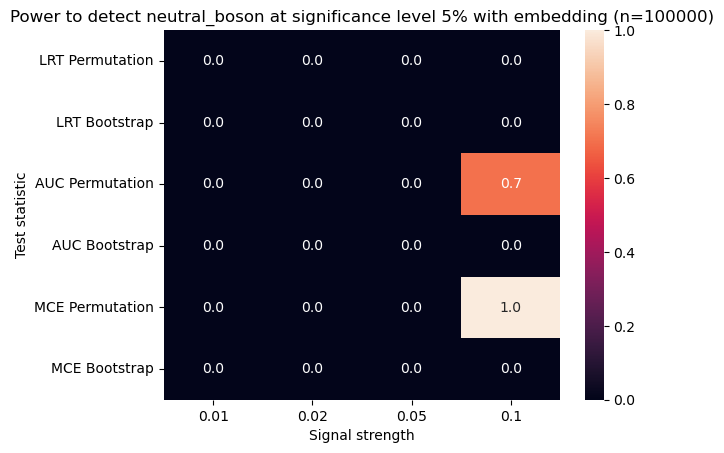

In [109]:
import seaborn as sns
ax = plt.axes()
sns.heatmap(power_df, annot=True, fmt=".1f", vmin=0, vmax=1)

ax.set_title("Power to detect {} at significance level {:.0%} with embedding (n={})".format(test_signal, significance, n))
plt.xlabel("Signal strength")
plt.ylabel("Test statistic")
plt.show()

In [53]:
h5file_name = "mlp_lambda_estimator_{}.h5".format(test_signal)
with pd.HDFStore(h5file_name) as store:
    store["power_df"] = power_df
    store["lambda_mean_dict"] = pd.Series(lambda_mean_dict)
    store["lambda_std_dict"] = pd.Series(lambda_std_dict)

## From pre-calculated null

In [9]:
import importlib
import classify
import analysis
importlib.reload(classify)
importlib.reload(analysis)
from classify import train_model
from analysis import Bootstrap_Permutation
opt_train_model  = torch.compile(train_model)
from analysis import LambdaEstimator

In [10]:
threshold_dict = load_toml_config("threshold")
print(threshold_dict)

{'lrt': 0.014815863868755264, 'mce': 0.49852925000000003, 'auc': 0.50212982325}


In [11]:
lambda_mean_dict = {}
lambda_std_dict = {}

lrt_p_dict = {}
auc_p_dict = {}
mce_p_dict = {}

In [12]:
hypothesis_dict = load_toml_config("hypothesis_test")
n = hypothesis_dict["n"]

In [14]:
n_bootstrap = 20


test_ratio=0.2
val_ratio = 0.2

test_signal = "neutral_boson"
# test_signal = "leptoquark"
# test_signal = "neutral_Higgs"
# test_signal = "charged_Higgs"
significance = 0.05


test_lambdas = [0.01, 0.02, 0.05, 0.1]

for i in tqdm(range(len(test_lambdas)), position=0, leave=True):
    sig_lambda = test_lambdas[i]

    estimated_lambdas = np.zeros(n_bootstrap)

    lrt_power = 0
    auc_power = 0
    mce_power = 0
    for j in tqdm(range(n_bootstrap), position=1, leave=False):
        exp_events, bkg_events = create_exp_bkg_events(np.array(embedding_points['SM']), np.array(embedding_points[test_signal]), sig_lambda, n)
        X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
        n1 = len(W1)
        m1 = len(X1)
        n2 = len(W2)
        m2 = len(X2)
        train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=1000, val_batch_size=1000, num_workers=16, prefetch_factor=8)

        hidden_dim = [8, 16, 16, 16, 8]
        naive_model = MLP(output_dim, hidden_sizes=hidden_dim)
        naive_model.to(device)
        optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
        loss_fn = nn.BCELoss()
        acc_metric = BinaryACCUpdater()
        metric_dict = {"Accuracy": acc_metric}

        train_model(
            naive_model, optimizer,
            loss_fn, metrics_dict=metric_dict,
            train_dataloader=train_dataloader, val_dataloader=val_dataloader,
            monitor="val_Accuracy", mode="max",
            epochs=50,
            verbose=False
            )
        
        bootstrap_permutation = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)

        if bootstrap_permutation.lrt_exp > threshold_dict["lrt"]:
            lrt_power += 1
        # else:
        #     print("rejected lrt:", bootstrap_permutation.lrt_exp, "lambda:", sig_lambda)

        if bootstrap_permutation.mce_exp < threshold_dict["mce"]:
            mce_power += 1
        # else:
        #     print("rejected mce:", bootstrap_permutation.mce_exp, "lambda:", sig_lambda)

        if bootstrap_permutation.auc_exp > threshold_dict["auc"]:
            auc_power += 1
        # else:
        #     print("rejected auc:", bootstrap_permutation.auc_exp, "lambda:", sig_lambda)

        lambda_estimator = LambdaEstimator(X2, W2, naive_model, T=0.5, n_bins=20, normalizer=normalizer)
        estimated_lambdas[j] = lambda_estimator.estimated_lambda
    print("sig_lambda:", sig_lambda, "estimated lambda mean:", estimated_lambdas.mean(), "estimated lambda std:", estimated_lambdas.std())
    lambda_mean_dict[str(sig_lambda)] = estimated_lambdas.mean()
    lambda_std_dict[str(sig_lambda)] = estimated_lambdas.std(ddof = 1)
    lrt_p_dict[str(sig_lambda)] = lrt_power

    auc_p_dict[str(sig_lambda)] = auc_power

    mce_p_dict[str(sig_lambda)] = mce_power


  0%|          | 0/4 [00:02<?, ?it/s]


NameError: name 'MLP' is not defined

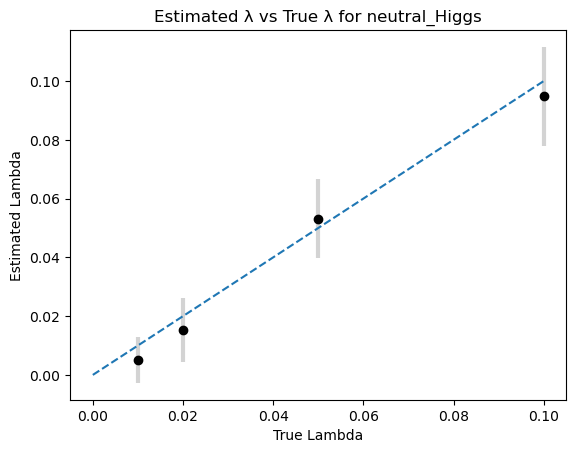

In [28]:
from visualize import plot_lambda
plot_lambda(lambda_mean_dict, lambda_std_dict, test_signal)

In [36]:
import pandas as pd
power_df = pd.DataFrame(columns=test_lambdas)
power_df.loc["LRT"] = [lrt_p_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["AUC"] = [auc_p_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["MCE"] = [mce_p_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]

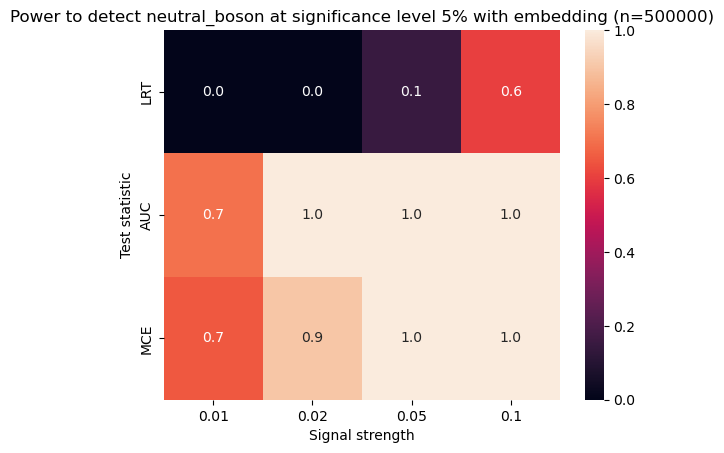

In [37]:
import seaborn as sns
ax = plt.axes()
sns.heatmap(power_df, annot=True, fmt=".1f", vmin=0, vmax=1)

ax.set_title("Power to detect {} at significance level {:.0%} with embedding (n={})".format(test_signal, significance, n))
plt.xlabel("Signal strength")
plt.ylabel("Test statistic")
plt.show()

In [21]:
import importlib
import analysis
importlib.reload(analysis)
from analysis import create_exp_bkg_from_multi_sig

 25%|██▌       | 1/4 [09:10<27:30, 550.33s/it]

sig_lambda: 0.01 estimated lambda mean: 0.005039363436621075 estimated lambda std: 0.007568758107868904


 50%|█████     | 2/4 [20:02<20:20, 610.36s/it]

sig_lambda: 0.02 estimated lambda mean: 0.015341459919951218 estimated lambda std: 0.010717004241299637


 75%|███████▌  | 3/4 [29:34<09:52, 592.60s/it]

sig_lambda: 0.05 estimated lambda mean: 0.053185240062065375 estimated lambda std: 0.013125259765310694


100%|██████████| 4/4 [39:15<00:00, 588.92s/it]

sig_lambda: 0.1 estimated lambda mean: 0.0947437623140652 estimated lambda std: 0.016439936343944618


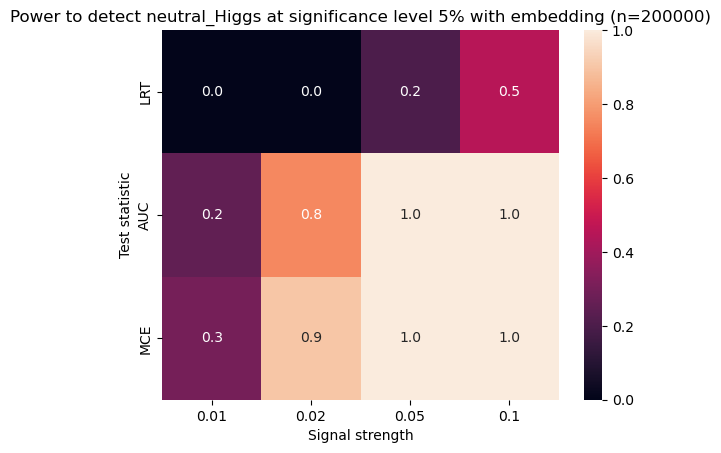

In [26]:
n_bootstrap = 20


test_ratio=0.2
val_ratio = 0.2

test_signals = ["neutral_boson", "leptoquark", "neutral_Higgs", "charged_Higgs"]
significance = 0.05


test_lambdas = [0.01, 0.02, 0.05, 0.1]
signal_ratio = [1, 1, 1, 1]

for i in tqdm(range(len(test_lambdas)), position=0, leave=True):
    sig_lambda = test_lambdas[i]

    estimated_lambdas = np.zeros(n_bootstrap)

    lrt_power = 0
    auc_power = 0
    mce_power = 0
    for j in tqdm(range(n_bootstrap), position=1, leave=False):
        sig_formula_dict = {}
        signal_ratio = np.array(signal_ratio) / np.sum(signal_ratio)
        for k in range(len(test_signals)):
            sig_formula_dict[test_signals[k]] = signal_ratio[k] * test_lambdas[i]
        exp_events, bkg_events = create_exp_bkg_from_multi_sig(embedding_points, sig_formula_dict, n)
        X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
        n1 = len(W1)
        m1 = len(X1)
        n2 = len(W2)
        m2 = len(X2)
        train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=1000, val_batch_size=1000, num_workers=16, prefetch_factor=8)

        hidden_dim = [8, 16, 16, 16, 8]
        naive_model = MLP(output_dim, hidden_sizes=hidden_dim)
        naive_model.to(device)
        optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
        loss_fn = nn.BCELoss()
        acc_metric = BinaryACCUpdater()
        metric_dict = {"Accuracy": acc_metric}

        train_model(
            naive_model, optimizer,
            loss_fn, metrics_dict=metric_dict,
            train_dataloader=train_dataloader, val_dataloader=val_dataloader,
            monitor="val_Accuracy", mode="max",
            epochs=50,
            verbose=False
            )
        
        bootstrap_permutation = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)

        if bootstrap_permutation.lrt_exp > threshold_dict["lrt"]:
            lrt_power += 1
        # else:
        #     print("rejected lrt:", bootstrap_permutation.lrt_exp, "lambda:", sig_lambda)

        if bootstrap_permutation.mce_exp < threshold_dict["mce"]:
            mce_power += 1
        # else:
        #     print("rejected mce:", bootstrap_permutation.mce_exp, "lambda:", sig_lambda)

        if bootstrap_permutation.auc_exp > threshold_dict["auc"]:
            auc_power += 1
        # else:
        #     print("rejected auc:", bootstrap_permutation.auc_exp, "lambda:", sig_lambda)

        lambda_estimator = LambdaEstimator(X2, W2, naive_model, T=0.5, n_bins=20, normalizer=normalizer)
        estimated_lambdas[j] = lambda_estimator.estimated_lambda
    print("sig_lambda:", sig_lambda, "estimated lambda mean:", estimated_lambdas.mean(), "estimated lambda std:", estimated_lambdas.std())
    lambda_mean_dict[str(sig_lambda)] = estimated_lambdas.mean()
    lambda_std_dict[str(sig_lambda)] = estimated_lambdas.std(ddof = 1)
    lrt_p_dict[str(sig_lambda)] = lrt_power

    auc_p_dict[str(sig_lambda)] = auc_power

    mce_p_dict[str(sig_lambda)] = mce_power

import pandas as pd
power_df = pd.DataFrame(columns=test_lambdas)
power_df.loc["LRT"] = [lrt_p_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["AUC"] = [auc_p_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["MCE"] = [mce_p_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]

import seaborn as sns
ax = plt.axes()
sns.heatmap(power_df, annot=True, fmt=".1f", vmin=0, vmax=1)

ax.set_title("Power to detect {} at significance level {:.0%} with embedding (n={})".format(test_signal, significance, n))
plt.xlabel("Signal strength")
plt.ylabel("Test statistic")
plt.show()

# Interpreting the Classifier

In [131]:
from analysis import h_hat
import seaborn as sns

In [132]:
targets, predictions = predict(naive_model, val_dataloader)

100%|██████████| 125/125 [00:00<00:00, 976.88it/s]


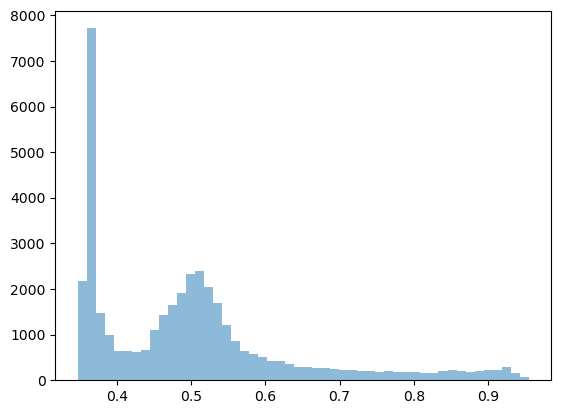

In [133]:
X2_W2 = np.concatenate((X2, W2))
h_hat_X2_W2 = h_hat(naive_model, X2_W2, normalizer)
plt.hist(h_hat_X2_W2, bins=50, alpha=0.5, label="X2")
plt.show()

In [134]:
bkg_index = h_hat_X2_W2 < 0.5
exp_index = h_hat_X2_W2 >= 0.5

In [135]:
from utils import embed_dict
sig_color = load_toml_config("sig_color")
bkg_dict = embed_dict(X2_W2[bkg_index], "SM")
exp_dict = embed_dict(X2_W2[exp_index], test_signal)
bkg_df = pd.DataFrame(bkg_dict)
exp_df = pd.DataFrame(exp_dict)
df = pd.concat([bkg_df, exp_df])

In [136]:
df

,type,Dimension 1,Dimension 2,Dimension 3,Dimension 4
0,SM,165.051651,-216.130646,-158.732086,172.506134
1,SM,252.171295,-176.657074,-192.473267,156.381424
2,SM,204.834244,-223.979370,-159.680405,190.799255
3,SM,212.092209,-228.334976,-153.379791,186.946198
4,SM,193.345840,-243.319672,-200.158432,162.038925
...,...,...,...,...,...
17656,neutral_Higgs,78.402679,-114.643799,71.189865,161.975159
17657,neutral_Higgs,183.925751,-82.965836,-83.755936,22.693949
17658,neutral_Higgs,206.059250,-117.312256,-158.006531,69.329239
17659,neutral_Higgs,129.445129,2.807575,69.525246,14.113441


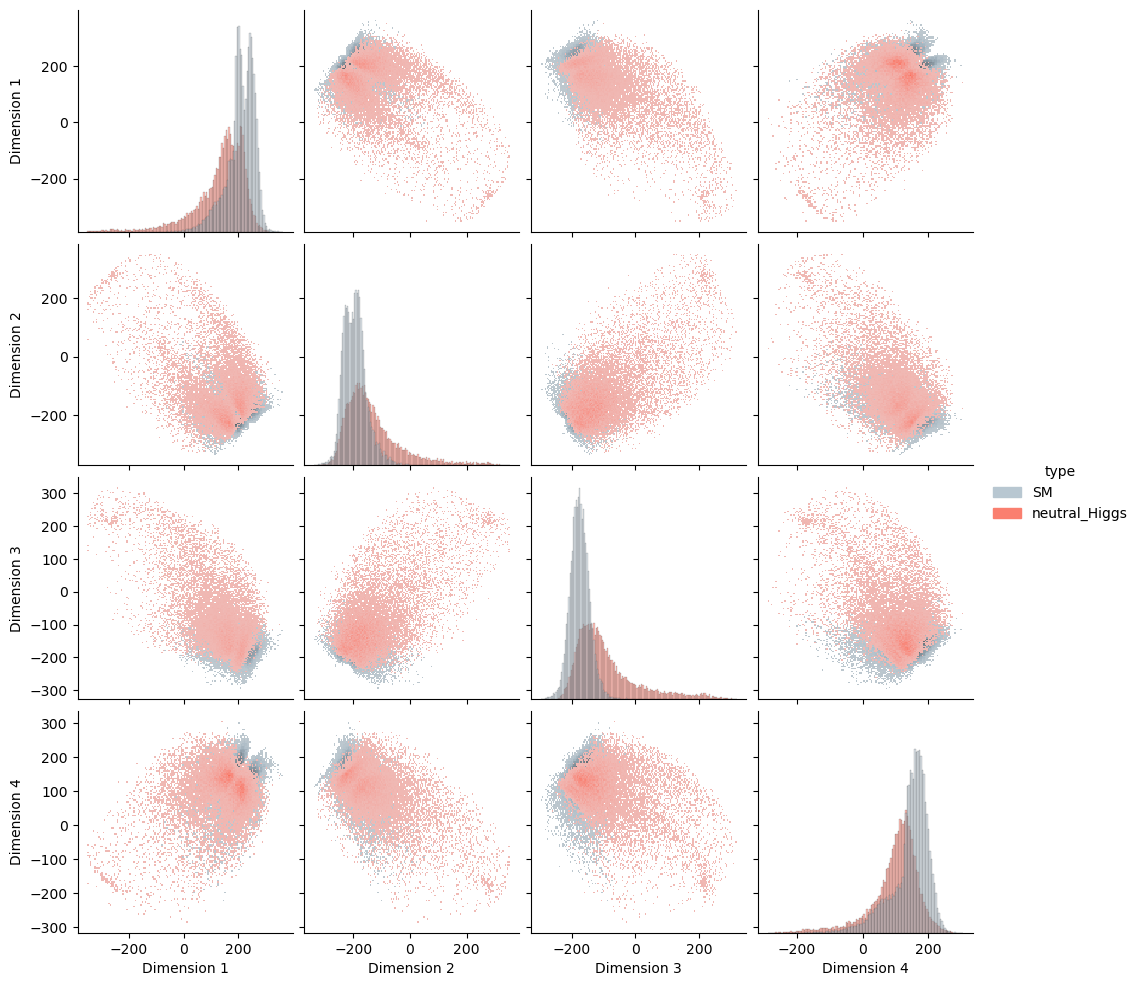

In [137]:
sns.pairplot(df, hue="type", kind="hist", palette=sig_color)
plt.show()

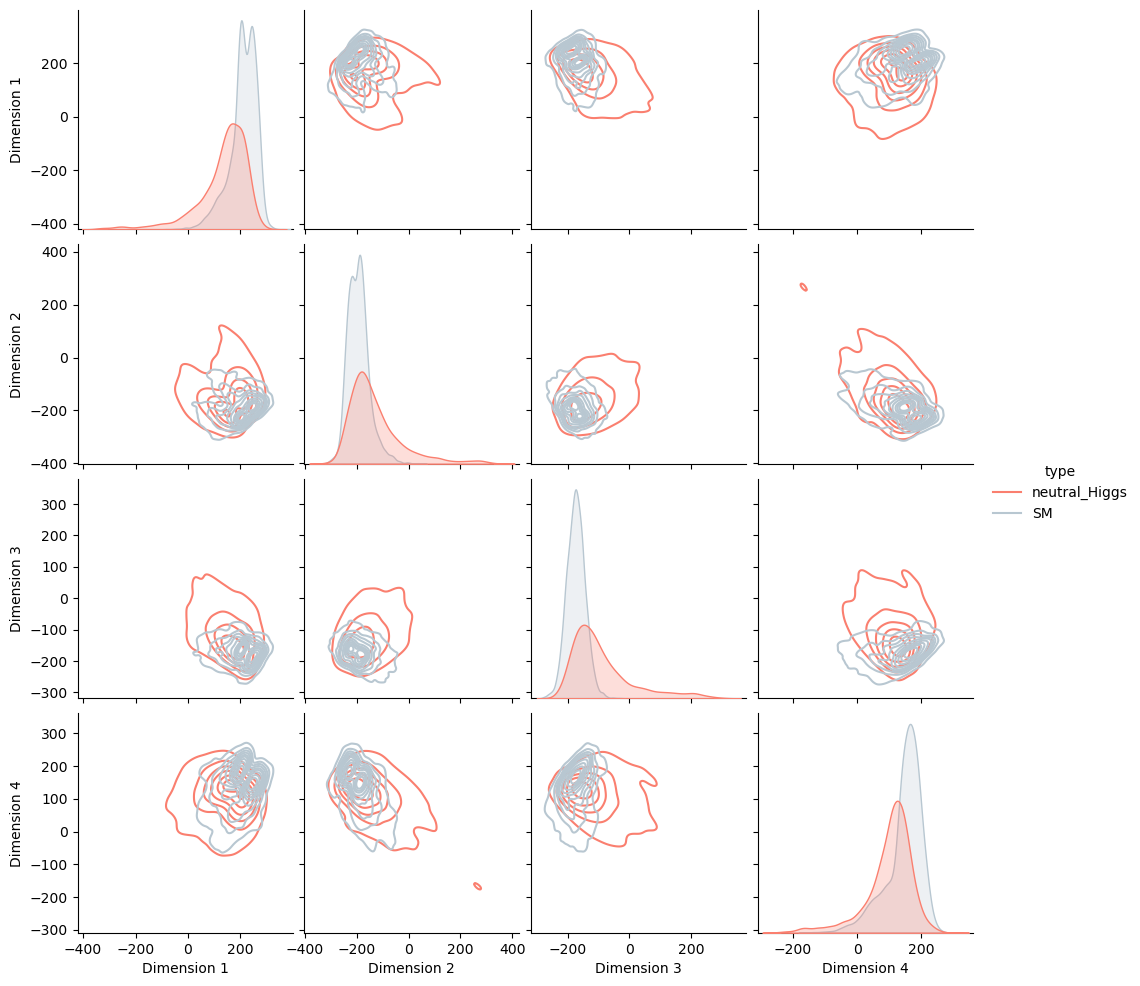

In [138]:
from visualize import downsample_and_visualize_pairplot
downsample_and_visualize_pairplot(df, 10000, sig_color)

In [139]:
def logit(h):
    return np.log(h / (1 - h))

In [140]:
H_predictions = logit(predictions)

In [141]:
print(H_predictions.max(), H_predictions.min()) 
print(H_predictions.shape)
print(predictions.shape)

3.104259060698414 -0.6278033788702192
(32000,)
(32000,)


In [142]:
X1[0]

array([ 206.94348145, -226.58529663, -156.35189819,  192.46748352])

In [143]:
input_vector = torch.tensor(normalizer(X1[0]), requires_grad=True).float().to(device)
input_vector.retain_grad()  # Non-leaf tensor requires grad

output = naive_model(input_vector)
print(output)

output.backward()

input_grad = input_vector.grad

print("Input Vector Gradient: ", input_grad)

tensor([0.3628], device='cuda:0', grad_fn=<ViewBackward0>)
Input Vector Gradient:  tensor([-0.4733,  0.3140,  0.2160, -0.1424], device='cuda:0')


In [144]:
def gradient(input_vector, model, normalizer):
    input_vector = torch.tensor(normalizer(input_vector), requires_grad=True).float().to(device)
    input_vector.retain_grad()  # Non-leaf tensor requires grad

    output = model(input_vector)
    logit = torch.log(output / (1 - output))
    logit.backward()

    input_grad = input_vector.grad

    return input_grad.to("cpu").detach().numpy()

In [145]:
gradient(X1[3], naive_model, normalizer)

array([0.5332562, 1.187391 , 1.2549163, 0.2671169], dtype=float32)

In [146]:
def estimate_gradient(X, model, normalizer):
    gradients = []
    for i in range(len(X)):
        gradients.append(gradient(X[i], model, normalizer))
    return np.array(gradients)

In [147]:
beta_x2 = estimate_gradient(X2, naive_model, normalizer)
beta_w2 = estimate_gradient(W2, naive_model, normalizer)
print(beta_x2.shape, beta_w2.shape)
beta_composed = np.concatenate([beta_x2, beta_w2], axis=0)
print(beta_composed.shape)

(20000, 4) (20000, 4)
(40000, 4)


In [148]:
output_dict = {"type": [test_signal] * len(beta_composed)}
for i in range(beta_composed.shape[1]):
    output_dict["Gradient on dimension {}".format(i+1)] = beta_composed[:, i]

In [149]:
gradient_df = pd.DataFrame(output_dict)

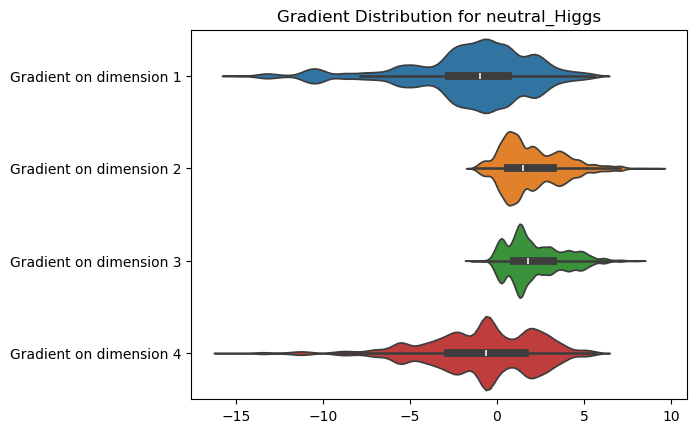

In [150]:
sns.violinplot(gradient_df, orient='h')
plt.title("Gradient Distribution for {}".format(test_signal))
plt.show()

In [151]:
standardized_beta = beta_composed / beta_composed.std(axis=0, ddof=1)
beta_mean = standardized_beta.mean(axis=0)
convariance_matrix = np.cov(standardized_beta.T, ddof=1)

In [152]:
print(convariance_matrix.shape)

(4, 4)


In [153]:
print(convariance_matrix)

[[ 1.00001084e+00 -1.81921354e-01  2.03552744e-05  7.30617255e-01]
 [-1.81921354e-01  1.00005005e+00  6.08797663e-01 -4.95428230e-01]
 [ 2.03552744e-05  6.08797663e-01  9.99987989e-01  1.35019525e-01]
 [ 7.30617255e-01 -4.95428230e-01  1.35019525e-01  1.00003680e+00]]


In [154]:
from sklearn.decomposition import PCA

In [155]:
pca = PCA(n_components=None)
pca.fit(convariance_matrix)
print('保留的主成分个数：' ,pca.n_components_)
print('保留的特征向量：\n',pca.components_)
print('保留的n个主成分各自方差：\n',pca.explained_variance_)

print('保留的n个主成分对原始数据信息累计解释的贡献率：\n',np.cumsum(pca.explained_variance_ratio_))

保留的主成分个数： 4
保留的特征向量：
 [[-0.47491608  0.59245062  0.33152647 -0.55995284]
 [-0.32173014 -0.22719645  0.77632881  0.49212303]
 [-0.78516108 -0.45168123 -0.4193734  -0.06026685]
 [ 0.23338063 -0.62719064  0.33396068 -0.66380392]]
保留的n个主成分各自方差：
 [1.33534633e+00 9.89391409e-02 1.78502684e-02 2.20447398e-34]
保留的n个主成分对原始数据信息累计解释的贡献率：
 [0.91957404 0.98770758 1.         1.        ]


In [156]:
h5file_name = "gradient_{}.h5".format(test_signal)
with pd.HDFStore(h5file_name) as store:
    store["gradient"] = gradient_df
    store["covariance_matrix"] = pd.DataFrame(convariance_matrix)